In [ ]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

from pycocotools import mask as coco_mask


In [ ]:
with open('_annotations.coco.json', 'r') as f:
    coco_data = json.load(f)

print(coco_data)

{'info': {'year': '2024', 'version': '1', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2024-10-12T00:43:30+00:00'}, 'licenses': [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}], 'categories': [{'id': 0, 'name': 'butterfly', 'supercategory': 'none'}, {'id': 1, 'name': 'butterfly', 'supercategory': 'butterfly'}], 'images': [{'id': 0, 'license': 1, 'file_name': 'beautiful-apollo_webp.rf.95a3ad09a8ccf4286211ce31a12c16f0.jpg', 'height': 640, 'width': 640, 'date_captured': '2024-10-12T00:43:30+00:00'}, {'id': 1, 'license': 1, 'file_name': 'beautiful-apollo_webp.rf.7a4b132ba1a5a95d78005df14c70d155.jpg', 'height': 640, 'width': 640, 'date_captured': '2024-10-12T00:43:30+00:00'}, {'id': 2, 'license': 1, 'file_name': 'c40bbff6_jpg.rf.074b553d10f4cf100b34c6e7fad8fe38.jpg', 'height': 640, 'width': 640, 'date_captured': '2024-10-12T00:43:30+00:00'}, {'id': 3, '

In [ ]:
image_info = coco_data['images'][0]
print(image_info)

{'id': 0, 'license': 1, 'file_name': 'beautiful-apollo_webp.rf.95a3ad09a8ccf4286211ce31a12c16f0.jpg', 'height': 640, 'width': 640, 'date_captured': '2024-10-12T00:43:30+00:00'}


In [ ]:
image_path = f"{image_info['file_name']}"
print(image_path)

beautiful-apollo_webp.rf.95a3ad09a8ccf4286211ce31a12c16f0.jpg


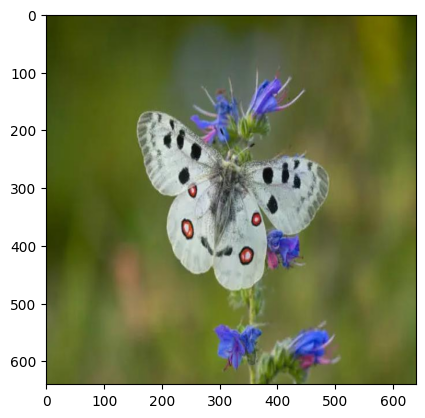

In [ ]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
coco_data['annotations']

In [ ]:
image_info['id']


0

In [ ]:
from __future__ import annotations
# extract annotation for particular image
annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_info['id']]
print(annotations)

[{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [157, 168, 331.579, 308.911], 'area': 102428.348, 'segmentation': [[209.474, 377.03, 220, 410.297, 234.737, 432.475, 251.579, 446.733, 266.316, 448.317, 289.474, 440.396, 296.842, 460.99, 317.895, 476.832, 352.632, 472.079, 372.632, 453.069, 380, 410.297, 378.947, 370.693, 392.632, 364.356, 411.579, 380.198, 436.842, 377.03, 456.842, 359.604, 487.368, 308.911, 488.421, 280.396, 483.158, 270.891, 451.579, 250.297, 411.579, 245.545, 332.632, 262.97, 306.316, 251.881, 294.737, 236.04, 206.316, 171.089, 176.842, 167.921, 161.053, 179.01, 156.842, 205.941, 173.684, 275.644, 188.421, 300.99, 216.842, 327.921, 209.474, 353.267, 209.474, 377.03]], 'iscrowd': 0}]


In [ ]:
# mask
mask = np.zeros((image_info['height'], image_info['width']), dtype = np.uint64)
print(mask)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


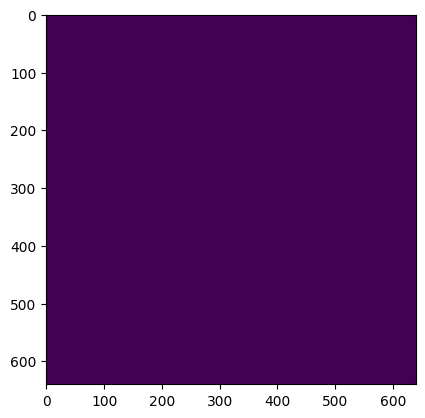

In [ ]:
plt.imshow(mask)

In [ ]:
# Now we read through image annotations and append in above empty mask
# create function
def create_binary_mask(segmentations, image_height, image_width):
  mask_temp = np.zeros((image_height, image_width), dtype = np.uint8)
  for seg in segmentations:
    poly = np.array(seg).reshape((len(seg)//2, 2))
    cv2.fillPoly(mask_temp, [np.int32(poly)], 1)
  return mask_temp


for ann in annotations:
  # go through annotation
  # update the mask
  binary_mask = create_binary_mask(ann['segmentation'], image_info['height'], image_info['width'])
  mask = np.maximum(mask, binary_mask) # original mask is 0, new one is 1, will be appended


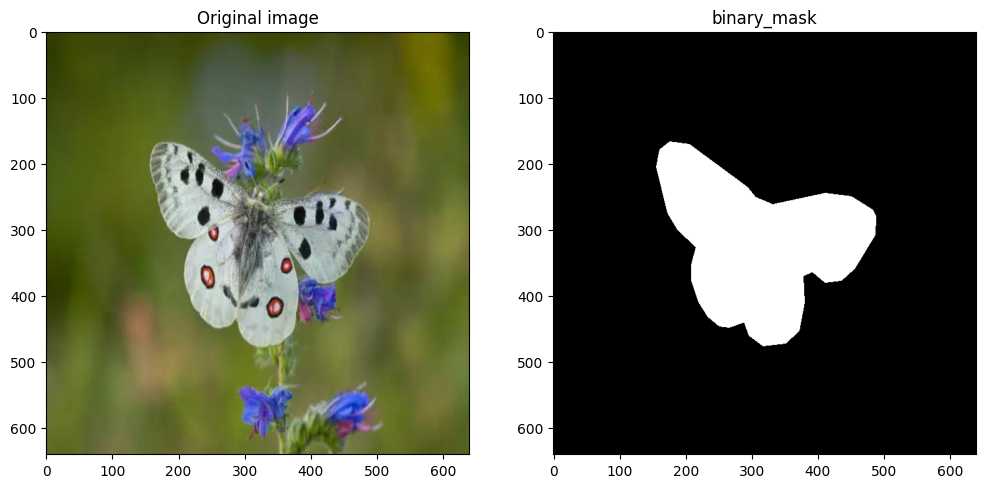

In [ ]:
# visualize
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original image")
plt.subplot(1,2,2)
plt.imshow(mask, cmap = 'gray')
plt.title("binary_mask")

plt.show()

In [ ]:
# to save masked image
# scale the mask to 0-255 for visibility
mask_scaled = (mask * 255)

cv2.imwrite("new_masked_image.png", mask_scaled)

True

### Now ler's write class to do all above steps all together on our dataset

In [ ]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

class COCOProcessor:
  def __init__(self, coco_annotation_file, image_dir):
    """
    Initialize the processor with the COCO annotation file and image directory.
    :param coco_annotation_file: Path to the COCO annotation JSON file.
    :param image_dir: Directory where the images are stored.
    """
    self.coco_annotation_file = coco_annotation_file
    self.image_dir = image_dir
    self.coco_data = self._load_coco_annotations()

  def _load_coco_annotations(self):
    """
    Load the COCO annotation JSON file.
    :return: Loaded COCO data.
    """
    try:
      with open(self.coco_annotation_file, 'r') as f:
        coco_data = json.load(f)
      return coco_data
    except FileNotFoundError:
      print(f"Error: COCO annotation file '{self.coco_annotation_file}' not found.")
      raise

  def create_binary_mask(self, segmentation, image_height, image_width):
    """
    Create a binary mask for the provided segmentation data.
    :param segmentations: List of segmentation points.
    :param image_height: Height of the image.
    :param image_width: Width of the image.
    :return: Binary mask.
    """
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    for seg in segmentation:
      # Convert segementation coordinates into a proper polygon
      poly = np.array(seg).reshape((len(seg) // 2, 2))
      cv2.fillPoly(mask, [np.int32(poly)], 1)
    return mask

  def save_mask(self, mask, image_info):
    """
    Save the binary mask to a file.
    :param mask: Binary mask to be saved
    :param image_info: Image metadata from the COCO data.
    :return: The file path where the mask is saved.
    """
    # Scale the mask for better visibility (0-255)
    mask_scaled = (mask * 255)
    # Generate file path for saving
    mask_save_path = f"{self.image_dir}/{image_info['file_name'].split('.')[0]}_mask.png"
    # save mask
    cv2.imwrite(mask_save_path, mask_scaled)
    return mask_save_path

  def process_image(self, image_id):
    """
    Process an image by generating and saving its binary mask.
    :param image_id: ID of the image to process.
    :return: None
    """
    # get image information by image_id
    image_info = self.coco_data['images'][image_id]
    image_path = f"{self.image_dir}/{image_info['file_name']}"

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
      raise ValueError(f"Image file {image_info['file_name']} not found in directory {self.image_dir}.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB

    # get annotations for the image
    annotations = [ann for ann in self.coco_data['annotations'] if ann['image_id']==image_info['id']]

    # Create binary mask
    mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
    for ann in annotations:
      binary_mask = self.create_binary_mask(ann['segmentation'], image_info['height'], image_info['width'])
      mask = np.maximum(mask, binary_mask) # merge all masks

    # Save the mask
    mask_save_path = self.save_mask(mask, image_info)

  def visualize(self, image, mask_save_path):
    """
    Visualize the original image and the generated mask.
    :param image: Original image.
    :param mask_save_path: Path to the saved mask.
    :return: None
    """
    # Load saved mask
    saved_mask = cv2.imread(mask_save_path, cv2.IMREAD_GRAYSCALE)
    # Display the original and mask
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(saved_mask, cmap='gray')
    plt.title("Binary Mask")
    plt.show()







### Example usage

In [ ]:
coco_annotation_file = '_annotations.coco.json'
image_dir = '.'

# create an instance of COCOProcessor
processor = COCOProcessor(coco_annotation_file, image_dir)

# Process the first image

processor.process_image(0)



